# Q-Learning pour prédiction de cours d'actifs

## Importation des packages

In [1]:
%matplotlib inline
from pathlib import Path
from time import *
from collections import deque
from random import sample

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import gym
from gym.envs.registration import register

## Vérification des versions

In [2]:
print('Python     version {}'.format(sys.version))
print('Numpy      version {}'.format(np.__version__))
print('Pandas     version {}'.format(pd.__version__))
print('Matplotlib version {}'.format(matplotlib.__version__))
print('Seaborn    version {}'.format(sns.__version__))
print('TensorFlow version {}'.format(tf.__version__))
print('Gym        version {}'.format(gym.__version__))

Python     version 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Numpy      version 1.21.4
Pandas     version 1.3.2
Matplotlib version 3.4.3
Seaborn    version 0.11.2
TensorFlow version 2.6.0
Gym        version 0.21.0


## Paramétrages

In [3]:
np.random.seed(167)
tf.random.set_seed(167)

In [4]:
# Permet d'utiliser TensorFlow sur le GPU (si possible)
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
  print('Utilisation du GPU')
except:
  print('Utilisation du CPU')

Utilisation du CPU


In [5]:
# Gestion des sauvegardes
results_path = Path('data', 'results', 'q-learning')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [6]:
# Création d'une fonction d'horodatage
t = time()
strftime('%H:%M:%S', gmtime(t))

'14:41:16'

## Configuration de l'environnement Gym 

In [7]:
# Basé sur la formule Nombre de jour dans l'année, moins les week-end, moins les jours féries de bourse fermé :
# 365 - 104 - 9 (Bourse US) = 252 jours
trading_days = 252

Pour la suite on utilisera un environnement propsé par le MIT en licence libre d'exploitation

In [8]:
register(id='du_ml_vers_la_fq-v0', 
         entry_point='trading_env:TradingEnvironment',
         max_episode_steps=trading_days)

### Création de l'environnement

In [9]:
# L'environnement tient compte du coût des transactions
trading_cost_bps = 1e-3 # on fixe à 10 points de base par défaut 
time_cost_bps = 1e-4    # on déduit un point de base par période sans transactions
                        # (de façon à décourager l'agent de ne pas investir ou vendre)

In [10]:
f'Coût de transaction: {trading_cost_bps:.2%} | Côut de période: {time_cost_bps:.2%}'

'Coût de transaction: 0.10% | Côut de période: 0.01%'

In [11]:
trading_environment = gym.make('du_ml_vers_la_fq-v0')
trading_environment.env.trading_days = trading_days
trading_environment.env.trading_cost_bps = trading_cost_bps
trading_environment.env.time_cost_bps = time_cost_bps
trading_environment.env.ticker = 'AAPL'
trading_environment.seed(42)

INFO:trading_env:trading_env logger démarré.
INFO:trading_env:chargement des données pour AAPL...
INFO:trading_env:données reçues pour AAPL !
INFO:trading_env:None


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10295 entries, (Timestamp('1981-01-30 00:00:00'), 'AAPL') to (Timestamp('2021-11-26 00:00:00'), 'AAPL')
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  10295 non-null  float64
 1   ret_2    10295 non-null  float64
 2   ret_5    10295 non-null  float64
 3   ret_10   10295 non-null  float64
 4   ret_21   10295 non-null  float64
 5   rsi      10295 non-null  float64
 6   macd     10295 non-null  float64
 7   atr      10295 non-null  float64
 8   stoch    10295 non-null  float64
 9   ultosc   10295 non-null  float64
dtypes: float64(10)
memory usage: 1.1+ MB


C:\Users\m.hayne\.conda\envs\du_ml_vers_la_fq\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


[42]

### Récupération du paramétrage de l'environnement

In [12]:
state_dim = trading_environment.observation_space.shape[0]
num_actions = trading_environment.action_space.n
max_episode_steps = trading_environment.spec.max_episode_steps

## Création de l'agent

In [13]:
class DDQNAgent:
    def __init__(self, state_dim,
                 num_actions,
                 learning_rate,
                 gamma,
                 epsilon_start,
                 epsilon_end,
                 epsilon_decay_steps,
                 epsilon_exponential_decay,
                 replay_capacity,
                 architecture,
                 l2_reg,
                 tau,
                 batch_size):

        self.state_dim     = state_dim
        self.num_actions   = num_actions
        self.experience    = deque([], maxlen=replay_capacity)
        self.learning_rate = learning_rate
        self.gamma         = gamma
        self.architecture  = architecture
        self.l2_reg        = l2_reg

        self.online_network = self.build_model()
        self.target_network = self.build_model(trainable=False)
        self.update_target()

        self.epsilon                   = epsilon_start
        self.epsilon_decay_steps       = epsilon_decay_steps
        self.epsilon_decay             = (epsilon_start - epsilon_end) / epsilon_decay_steps
        self.epsilon_exponential_decay = epsilon_exponential_decay
        self.epsilon_history           = []

        self.total_steps       = self.train_steps = 0
        self.episodes          = self.episode_length = self.train_episodes = 0
        self.steps_per_episode = []
        self.episode_reward    = 0
        self.rewards_history   = []

        self.batch_size = batch_size
        self.tau        = tau
        self.losses     = []
        self.idx        = tf.range(batch_size)
        self.train      = True

    def build_model(self, trainable=True):
        """
        Création d'un modèle séquentiel à partir de la bibliotèque Keras
        """
        layers = []
        n = len(self.architecture)
        for i, units in enumerate(self.architecture, 1):
            layers.append(Dense(units=units,
                                input_dim=self.state_dim if i == 1 else None,
                                activation='relu',
                                kernel_regularizer=l2(self.l2_reg),
                                name=f'Dense_{i}',
                                trainable=trainable))
        layers.append(Dropout(.1))
        layers.append(Dense(units=self.num_actions,
                            trainable=trainable,
                            name='Output'))
        model = Sequential(layers)
        model.compile(loss='mean_squared_error',
                      optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def update_target(self):
        self.target_network.set_weights(self.online_network.get_weights())

    def epsilon_greedy_policy(self, state):
        self.total_steps += 1
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        q = self.online_network.predict(state)
        return np.argmax(q, axis=1).squeeze()

    def memorize_transition(self, s, a, r, s_prime, not_done):
        if not_done:
            self.episode_reward += r
            self.episode_length += 1
        else:
            if self.train:
                if self.episodes < self.epsilon_decay_steps:
                    self.epsilon -= self.epsilon_decay
                else:
                    self.epsilon *= self.epsilon_exponential_decay

            self.episodes += 1
            self.rewards_history.append(self.episode_reward)
            self.steps_per_episode.append(self.episode_length)
            self.episode_reward, self.episode_length = 0, 0

        self.experience.append((s, a, r, s_prime, not_done))

    def experience_replay(self):
        if self.batch_size > len(self.experience):
            return
        minibatch = map(np.array, zip(*sample(self.experience, self.batch_size)))
        states, actions, rewards, next_states, not_done = minibatch

        next_q_values = self.online_network.predict_on_batch(next_states)
        best_actions = tf.argmax(next_q_values, axis=1)

        next_q_values_target = self.target_network.predict_on_batch(next_states)
        target_q_values = tf.gather_nd(next_q_values_target,
                                       tf.stack((self.idx, tf.cast(best_actions, tf.int32)), axis=1))

        targets = rewards + not_done * self.gamma * target_q_values

        q_values = self.online_network.predict_on_batch(states)
        q_values[[self.idx, actions]] = targets

        loss = self.online_network.train_on_batch(x=states, y=q_values)
        self.losses.append(loss)

        if self.total_steps % self.tau == 0:
            self.update_target()

## Définition des hyper-paramètres

In [14]:
gamma = .99,    # coefficient d'actualisation
tau = 100       # fréquence de mise à jour du réseau

#### Architécture du réseau de neuronnes

In [15]:
architecture = (256, 256)   # unités par couches
learning_rate = 0.0001      # taux d'apprentissage
l2_reg = 1e-6               # régularisation L2 
                            # l'objectif est de minimiser le risque structurel (i.e. la perte ainsi que la complexité)

In [16]:
replay_capacity = int(1e6)
batch_size = 4096

#### Paramétrage de la méthode Epsilon-Greedy

In [17]:
epsilon_start = 1.0
epsilon_end = .01   # On choisi naturellement un epsilon plus précis en fin d'algortihme
epsilon_decay_steps = 250
epsilon_exponential_decay = .99

## Création de de l'agent

In [18]:
tf.keras.backend.clear_session()

In [19]:
ddqn = DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size)

In [20]:
ddqn.online_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dense_1 (Dense)              (None, 256)               2816      
_________________________________________________________________
Dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
Output (Dense)               (None, 3)                 771       
Total params: 69,379
Trainable params: 69,379
Non-trainable params: 0
_________________________________________________________________


## Réalisation de l'expérience

### Initialisation des paramètres

In [21]:
total_steps = 0
max_episodes = 1000

In [22]:
episode_time, navs, market_navs, diffs, episode_eps = [], [], [], [], []

### Préparation de la visualisation

In [23]:
def track_results(episode, nav_ma_100, nav_ma_10,
                  market_nav_100, market_nav_10,
                  win_ratio, total, epsilon):
    time_ma = np.mean([episode_time[-100:]])
    T = np.sum(episode_time)
    
    template = '{:>4d} | {} | Agent: {:>6.1%} ({:>6.1%}) | '
    template += 'Market: {:>6.1%} ({:>6.1%}) | '
    template += 'Wins: {:>5.1%} | eps: {:>6.3f}'
    print(template.format(episode, strftime('%H:%M:%S', gmtime(total)), 
                          nav_ma_100-1, nav_ma_10-1, 
                          market_nav_100-1, market_nav_10-1, 
                          win_ratio, epsilon))

### Entrainement de l'agent

In [24]:
start = time()
results = []
for episode in range(1, max_episodes + 1):
    this_state = trading_environment.reset()
    for episode_step in range(max_episode_steps):
        action = ddqn.epsilon_greedy_policy(this_state.reshape(-1, state_dim))
        next_state, reward, done, _ = trading_environment.step(action)
    
        ddqn.memorize_transition(this_state, 
                                 action, 
                                 reward, 
                                 next_state, 
                                 0.0 if done else 1.0)
        if ddqn.train:
            ddqn.experience_replay()
        if done:
            break
        this_state = next_state

    # get DataFrame with seqence of actions, returns and nav values
    result = trading_environment.env.simulator.result()
    
    # get results of last step
    final = result.iloc[-1]

    # apply return (net of cost) of last action to last starting nav 
    nav = final.nav * (1 + final.strategy_return)
    navs.append(nav)

    # market nav 
    market_nav = final.market_nav
    market_navs.append(market_nav)

    # track difference between agent an market NAV results
    diff = nav - market_nav
    diffs.append(diff)
    
    if episode % 10 == 0:
        track_results(episode, 
                      # show mov. average results for 100 (10) periods
                      np.mean(navs[-100:]), 
                      np.mean(navs[-10:]), 
                      np.mean(market_navs[-100:]), 
                      np.mean(market_navs[-10:]), 
                      # share of agent wins, defined as higher ending nav
                      np.sum([s > 0 for s in diffs[-100:]])/min(len(diffs), 100), 
                      time() - start, ddqn.epsilon)
    if len(diffs) > 25 and all([r > 0 for r in diffs[-25:]]):
        print(result.tail())
        break

trading_environment.close()

C:\Users\m.hayne\AppData\Roaming\Python\Python39\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\m.hayne\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


  10 | 00:00:04 | Agent: -14.3% (-14.3%) | Market:  21.4% ( 21.4%) | Wins: 20.0% | eps:  0.960


C:\Users\M5C0C~1.HAY\AppData\Local\Temp/ipykernel_27224/1764569925.py:112: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  q_values[[self.idx, actions]] = targets


  20 | 00:01:32 | Agent: -16.6% (-19.0%) | Market:  29.8% ( 38.2%) | Wins: 20.0% | eps:  0.921
  30 | 00:05:24 | Agent: -18.2% (-21.2%) | Market:  28.6% ( 26.3%) | Wins: 20.0% | eps:  0.881
  40 | 00:09:37 | Agent: -13.2% (  1.5%) | Market:  24.8% ( 13.3%) | Wins: 25.0% | eps:  0.842
  50 | 00:13:51 | Agent:  -7.8% ( 13.8%) | Market:  25.7% ( 29.1%) | Wins: 32.0% | eps:  0.802
  60 | 00:18:11 | Agent:  -9.9% (-20.4%) | Market:  26.5% ( 30.8%) | Wins: 28.3% | eps:  0.762
  70 | 00:22:26 | Agent: -12.0% (-24.4%) | Market:  26.1% ( 23.6%) | Wins: 25.7% | eps:  0.723
  80 | 00:27:00 | Agent: -13.1% (-20.7%) | Market:  25.3% ( 19.9%) | Wins: 23.8% | eps:  0.683
  90 | 00:31:44 | Agent: -12.9% (-11.5%) | Market:  28.0% ( 49.0%) | Wins: 22.2% | eps:  0.644
 100 | 00:36:34 | Agent: -13.0% (-13.2%) | Market:  29.8% ( 46.6%) | Wins: 23.0% | eps:  0.604
 110 | 00:41:37 | Agent: -13.1% (-15.7%) | Market:  30.4% ( 27.4%) | Wins: 23.0% | eps:  0.564
 120 | 00:46:49 | Agent: -11.6% ( -3.5%) | Market:

## Sauvegarde des résulats

In [ ]:
results = pd.DataFrame({'Episode': list(range(1, episode+1)),
                        'Agent': navs,
                        'Market': market_navs,
                        'Difference': diffs}).set_index('Episode')

results['Strategy Wins (%)'] = (results.Difference > 0).rolling(100).sum()
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              1000 non-null   float64
 1   Market             1000 non-null   float64
 2   Difference         1000 non-null   float64
 3   Strategy Wins (%)  901 non-null    float64
dtypes: float64(4)
memory usage: 39.1 KB


In [ ]:
results.to_csv(results_path / 'results.csv', index=False)

C:\Users\m.hayne\.conda\envs\du_ml_vers_la_fq\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


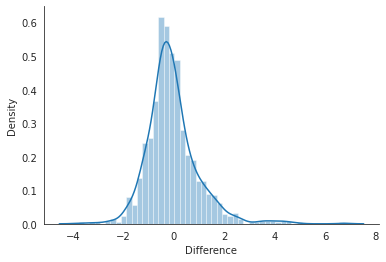

In [ ]:
with sns.axes_style('white'):
    sns.distplot(results.Difference)
    sns.despine()

## Evaluation des résulats

In [ ]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Agent              1000 non-null   float64
 1   Market             1000 non-null   float64
 2   Difference         1000 non-null   float64
 3   Strategy Wins (%)  901 non-null    float64
dtypes: float64(4)
memory usage: 39.1 KB


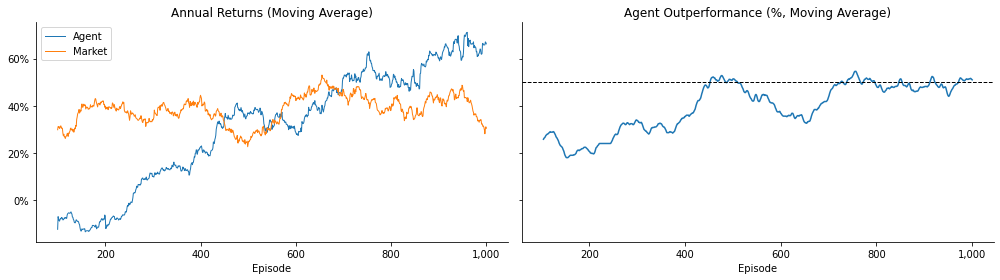

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

df1 = (results[['Agent', 'Market']]
       .sub(1)
       .rolling(100)
       .mean())
df1.plot(ax=axes[0],
         title='Annual Returns (Moving Average)',
         lw=1)

df2 = results['Strategy Wins (%)'].div(100).rolling(5).mean()
df2.plot(ax=axes[1],
         title='Agent Outperformance (%, Moving Average)')

for ax in axes:
    ax.yaxis.set_major_formatter(
        FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
axes[1].axhline(.5, ls='--', c='k', lw=1)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'performance', dpi=300)